# 03. Machine Learning (XGBoost) & Interpretability

**Project:** Swiss Rental Price Prediction<br>
**Author:** Dimitrios Mylonas

**Objective:**
Train a non-linear Gradient Boosting model (XGBoost) to outperform the linear baseline. Use SHAP (SHapley Additive exPlanations) to interpret the model's decisions and understand the drivers of Swiss rental prices.

**Methodology:**
1.  **Data Preparation:** Encode categorical variables for Tree-based models (Target Encoding for Zip, One-Hot for others).
2.  **Model Training:** Train an XGBoost Regressor.
3.  **Hyperparameter Tuning:** Use `RandomizedSearchCV` to optimize learning rate, depth, and regularization.
4.  **Evaluation:** Compare MAE against the baseline (641 CHF).
5.  **Interpretability:** Visualize feature importance using SHAP values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import category_encoders as ce

# Configuration
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style("whitegrid")

# Load Data
df = pd.read_pickle('../data/processed/02_featured_data.pkl')
print(f"Data loaded: {df.shape}")

Data loaded: (16005, 34)


## 1. Data Preparation for Tree Models
Unlike Linear Regression, XGBoost does not require scaling (StandardScaler). However, it requires all data to be numeric.
*   **Zip Code:** We use **Target Encoding** again (replacing Zip with the average rent of that Zip).
*   **Canton/SubType:** We use **One-Hot Encoding**.

In [2]:
# 1. Separate Target
X = df.drop(columns=['Rent'])
y = df['Rent']

# 2. Split (Must use SAME random_state as Notebook 02 to ensure fair comparison)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Encoding Pipeline
# We manually handle encoding here to keep full control over the columns for SHAP later
# A. Target Encode Zip
encoder_zip = ce.TargetEncoder(cols=['Zip'])
X_train['Zip_encoded'] = encoder_zip.fit_transform(X_train['Zip'], y_train)
X_test['Zip_encoded'] = encoder_zip.transform(X_test['Zip'])

# Drop original Zip
X_train = X_train.drop(columns=['Zip'])
X_test = X_test.drop(columns=['Zip'])

# B. One-Hot Encode others (Pandas get_dummies is easiest here)
# We align train and test to ensure they have the same columns
X_train = pd.get_dummies(X_train, columns=['Canton', 'SubType'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Canton', 'SubType'], drop_first=True)

# Ensure columns match (if a Canton appears in train but not test, fill with 0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print(f"Training Features: {X_train.shape[1]}")
X_train.head(3)

Training Features: 64


,is_rent_estimated,Lat,Lon,Rooms,Area_m2,Floor,Year_Built,year_built_is_missing,is_renovated,Balcony,Elevator,Parking,View,Fireplace,Child_Friendly,CableTV,New_Building,Minergie,Wheelchair,dist_to_Zurich_HB,dist_to_Geneva_Cornavin,dist_to_Basel_SBB,dist_to_Bern_HB,dist_to_Lausanne_Gare,dist_to_closest_hub,has_lake_view,is_attic,is_quiet,is_sunny,tax_rate,Zip_encoded,Canton_BE,Canton_BL,Canton_BS,Canton_FR,Canton_GE,Canton_GL,Canton_GR,Canton_JU,Canton_LU,Canton_NE,Canton_NW,Canton_OW,Canton_SG,Canton_SH,Canton_SO,Canton_SZ,Canton_TG,Canton_TI,Canton_UR,Canton_VD,Canton_VS,Canton_ZG,Canton_ZH,SubType_DUPLEX,SubType_FLAT,SubType_OTHER_TYPE,SubType_ROOF_FLAT,SubType_ROW_HOUSE,SubType_SINGLE_HOUSE,SubType_SINGLE_ROOM,SubType_STUDIO,SubType_TERRACE_FLAT,SubType_VILLA
676,0,47.423455,8.541652,1.5,12.0,1.0,NaN,1,1,1,1,0,1,0,1,0,0,0,1,5.035871,226.983063,72.858514,98.625103,176.694376,5.035871,1,0,0,0,217.0,2373.279302,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False
5528,0,46.531635,6.628832,1.5,12.0,6.0,1975.0,0,1,1,0,0,1,0,0,0,0,0,1,172.925403,51.669714,134.376473,77.230547,1.652245,1.652245,1,0,0,0,233.5,2261.447190,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
13177,0,47.179798,7.567847,4.5,88.0,3.0,1970.0,0,1,0,0,0,0,0,0,0,0,0,0,76.596047,153.099842,40.909476,27.470655,102.624622,27.470655,1,0,0,0,229.0,2031.634634,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


## 2. XGBoost Training (Default)
We start with a "Vanilla" XGBoost model to see the immediate improvement over the Linear Baseline.
*   **Objective:** `reg:absoluteerror`. We tell XGBoost explicitly to minimize MAE, as that is our KPI.

In [4]:
# Initialize XGBoost
# n_jobs=-1 uses all CPU cores
model_xgb = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

# Train
print("Training XGBoost...")
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

# Predict
y_pred = model_xgb.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print(f"\nDefault XGBoost MAE: {mae:.2f} CHF")

Training XGBoost...
[0]	validation_0-mae:936.29516
[100]	validation_0-mae:405.22393
[200]	validation_0-mae:382.87193
[300]	validation_0-mae:373.32903
[400]	validation_0-mae:368.83959
[500]	validation_0-mae:367.30254
[562]	validation_0-mae:367.56133

Default XGBoost MAE: 367.09 CHF


## 3. Hyperparameter Tuning
To squeeze the last bit of performance out, we tune the model.
*   `max_depth`: How complex the trees can be.
*   `learning_rate`: How fast the model learns (lower is usually better but slower).
*   `subsample`: Fraction of data to use for each tree (prevents overfitting).

In [5]:
# Define the grid
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 2000],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

# Randomized Search (Faster than GridSearch)
xgb_tuned = xgb.XGBRegressor(objective='reg:absoluteerror', n_jobs=-1, random_state=42)

search = RandomizedSearchCV(
    xgb_tuned, 
    param_distributions=param_grid, 
    n_iter=20, # Try 20 random combinations
    scoring='neg_mean_absolute_error', 
    cv=3, 
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

print(f"Best Params: {search.best_params_}")
print(f"Best CV MAE: {-search.best_score_:.2f} CHF")

# Save best model
best_model = search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'subsample': 0.7, 'n_estimators': 2000, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best CV MAE: 330.37 CHF


## 4. Final Evaluation
Let's look at the performance of the tuned model on the Test Set.

------------------------------
FINAL MODEL PERFORMANCE
MAE:  349.24 CHF
RMSE: 740.03 CHF
R2:   0.7901
------------------------------


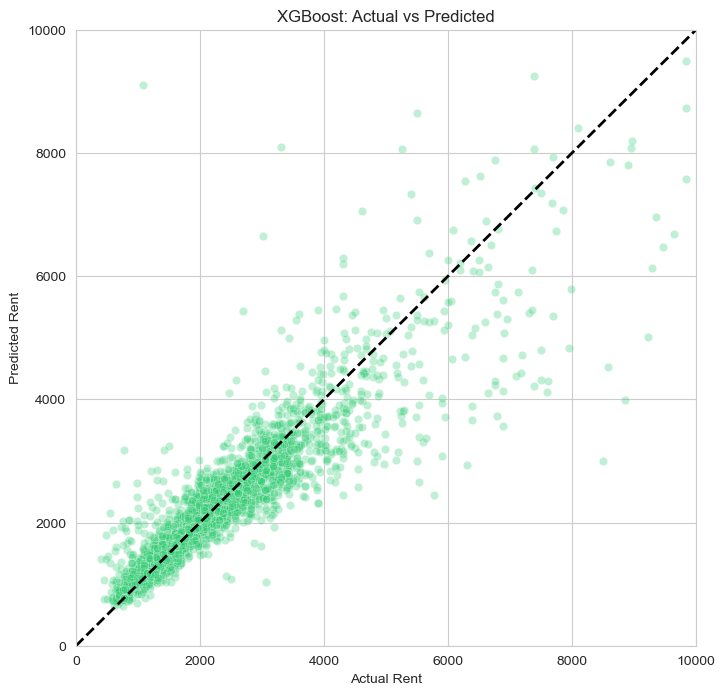

In [6]:
# Predict with Best Model
y_pred_final = best_model.predict(X_test)

# Metrics
mae_final = mean_absolute_error(y_test, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print("-" * 30)
print("FINAL MODEL PERFORMANCE")
print(f"MAE:  {mae_final:.2f} CHF")
print(f"RMSE: {rmse_final:.2f} CHF")
print(f"R2:   {r2_final:.4f}")
print("-" * 30)

# Visual Check
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.3, color='#2ecc71')
plt.plot([0, 15000], [0, 15000], 'k--', lw=2)
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('XGBoost: Actual vs Predicted')
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.show()

## 5. Model Explainability (SHAP)
This is the most important section for a Data Scientist. We don't just want a prediction; we want to know **why**.
*   **SHAP Summary Plot:** Shows which features are the most important drivers of price globally.

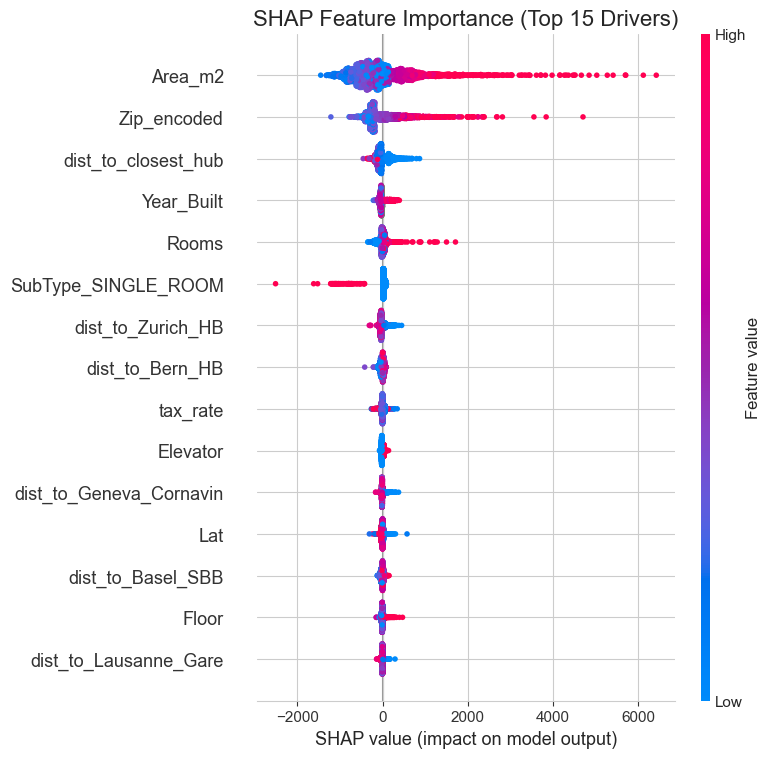

In [7]:
# 1. Create Explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# 2. Summary Plot (Beeswarm)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.title("SHAP Feature Importance (Top 15 Drivers)", fontsize=16)
plt.show()

### Interpretation
*   **Area_m2:** The red dots (high area) are on the far right (positive impact on price). This is the strongest driver.
*   **Zip_encoded:** Living in a high-value Zip code (red) massively increases price.
*   **Tax_Rate:** Lower tax rate (blue) should correlate with higher price (right side).
*   **Lake View:** Check the `has_lake_view` flag. Does it push prices up?

## 6. Export Model
We save the model and the encoder so we can build an interactive app (`app.py`).

In [9]:
# Save the model
with open('../models/xgb_rent_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the Zip Encoder (We need this to process user input in the app)
with open('../models/zip_encoder.pkl', 'wb') as f:
    pickle.dump(encoder_zip, f)

print("Model and Encoder saved to models/ folder.")

Model and Encoder saved to models/ folder.
